##Генетический алгоритм 
##Едленко С.А. 
##гр. 4.6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import random
import torch
import math

In [74]:
class GeneticAlgorithm:
    def __init__(self, population_size, num_genes, num_parents, mutation_prob, selection_method, parent_selection_method):
        self.population_size = population_size
        self.num_genes = num_genes
        self.num_parents = num_parents
        self.mutation_prob = mutation_prob
        self.selection_method = selection_method
        self.parent_selection_method = parent_selection_method
        self.population = np.random.uniform(low=[-20, -20], high=[20, 20], size=(self.population_size, self.num_genes))

        self.best_fitness = 100
        self.best_individual = [30. , 30.]
    
    def fitness(self, x, y):
        return -((3 / (x*x + 8)) + (5 / (y*y + 8)))
    #Турнирная селекция
    def tournament_selection(self, fitness_scores):
        selected_parents = np.zeros((self.population_size, self.num_genes)) # создаем пустой массив заданной размерности
        for i in range(self.num_parents):
            tournament = np.random.choice(self.population_size, size=2, replace=False) # выбираем индексы 2х случайных особей которые будут состязаться
            tournament_fitness = fitness_scores[tournament] # получаем значения функции выбранных особей
            winner = tournament[np.argmin(tournament_fitness)] # определяем наименьшее значение ф-ии
            selected_parents[i,:] = self.population[winner,:] # добавляем в массив
        return selected_parents
    #Метод рулетки
    def roulette_selection(self, fitness_scores):
        total_fitness = np.sum(fitness_scores) # сумма значений ф-ии особей
        relative_fitness = fitness_scores / total_fitness # вероятности 
        selected_parents = np.zeros((self.population_size, self.num_genes)) # объявляем массив популяции заданный 0
        selection_probabilities = np.zeros_like(fitness_scores) # объявляем массив вероятностей выбора особей
        # высчитываем вероятности выбора для особей
        for i in range(self.num_parents):
            selection_probabilities[i] = fitness_scores[i] / total_fitness
        selected_parents[: self.num_parents] = np.array(random.choices(self.population, weights=selection_probabilities, k=self.num_parents)) # выбираем особи в соответствии с вероятностями
        return selected_parents
    # Метод ранжирования
    def ranking_selection(self, fitness_scores):
        ranking = np.argsort(np.argsort(fitness_scores))
        selected_parents = np.zeros((self.population_size, self.num_genes))
        for i in range(self.num_parents):
            r = np.random.random()
            cum_sum = 0
            for j in range(self.population_size):
                cum_sum += (ranking[j] + 1) / self.population_size
                if r <= cum_sum:
                    selected_parents[i,:] = self.population[j,:]
                    break
        return selected_parents
    # Равномерное ранжирование
    def uniform_ranking_selection(self, fitness_scores):
        ranking = np.argsort(np.argsort(fitness_scores))
        fitness_ranks = np.zeros_like(fitness_scores)
        fitness_ranks[ranking <= self.population_size // 2] = 1
        fitness_ranks /= np.sum(fitness_ranks)
        selected_parents = np.empty((self.num_parents, self.num_genes))
        for i in range(self.num_parents):
            r = np.random.random()
            cum_sum = 0
            for j in range(self.population_size):
                cum_sum += fitness_ranks[j]
                if r <= cum_sum:
                    selected_parents[i,:] = self.population[j,:]
                    break
        return selected_parents
    # Сигма-отсечение 
    def sigma_pruning_selection(self, fitness_scores):
        mean_fitness = np.mean(fitness_scores)
        std_fitness = np.std(fitness_scores)
        threshold = mean_fitness - std_fitness
        selected_parents = self.population[fitness_scores >= threshold]
        if len(selected_parents) < self.num_parents:
            additional_parents = self.population[np.argsort(fitness_scores)[-self.num_parents+len(selected_parents):]]
            selected_parents = np.concatenate((selected_parents, additional_parents), axis=0)
        return selected_parents
    
    def panmixing_parent_selection(self):
        return np.random.permutation(self.population)[:self.num_parents,:] # перемешиваем популяцию и берем необходимое кол-во родителей
    
    def inbreeding_parent_selection(self):
        parents = np.zeros((self.num_parents, self.num_genes))
        for i in range(self.num_parents - 1):
          rand_index = np.random.randint(0, self.num_parents) # генерируем случайное число
          population = self.population[: self.num_parents] # копируем популяцию и удаляем выбранного родителя
          np.delete(population, rand_index)
          
          i_fitness = self.fitness(population[rand_index][0], population[rand_index][1]) # значение ф-ии 1-го родителя
          fitness_arr = self.fitness(population[:,0],population[:,1]) # вычисляем значения ф-ии для остальных
          nearest = min(fitness_arr, key=lambda x: abs(x - i_fitness)) # находим ближнего по значению

          parents[i] = self.population[rand_index]
          parents[i+1] = nearest
        return parents
    
    def outbreeding_parent_selection(self):
        parents = np.zeros((self.num_parents, self.num_genes))
        for i in range(self.num_parents - 1):
          rand_index = np.random.randint(0, self.num_parents) # генерируем случайное число
          population = self.population[: self.num_parents] # копируем популяцию и удаляем выбранного родителя
          np.delete(population, rand_index)
          
          i_fitness = self.fitness(population[rand_index][0], population[rand_index][1]) # значение ф-ии 1-го родителя
          fitness_arr = self.fitness(population[:,0],population[:,1]) # вычисляем значения ф-ии для остальных
          further = max(fitness_arr, key=lambda x: abs(x - i_fitness)) # находим дальнего по значению

          parents[i] = self.population[rand_index]
          parents[i+1] = further
        return parents
    
    # скрещивание
    def crossover(self, parents):
        offspring = np.zeros((self.num_parents, self.num_genes)) # создаем пустой массив для потомков
        for i in range(0, self.num_parents, 2): # проходимся по всем парам родителей
            point = np.random.randint(0, self.num_genes) # генерируем случайное число
            offspring[i,:point ] = parents[i,:point] # берем первую часть гена у первого родителя до точки пересечения
            offspring[i,point:] = parents[i+1,point:] # берем вторую часть гена у второго родителя от точки пересечения
            offspring[i+1,:point] = parents[i+1,:point] # то же самое для 2го потомка
            offspring[i+1,point:] = parents[i,point:]
        
        return np.array(offspring)

    # проходимся по детям добавляем мутацию
    def mutation(self, offspring):
        for i in range(self.num_parents):
            for j in range(self.num_genes):
                if np.random.uniform(0, 1) < self.mutation_prob:
                    offspring[i,j] = np.random.uniform(low=-20, high=20)
        return offspring
        # Сделать сортировку
    def sort_by_function(self, population):
        print('sort')

    def learn(self, num_generations):
        generation = 0
        mim_value_epochs_counter = 0      
        while mim_value_epochs_counter < num_generations:
            generation += 1

            fitness_scores = self.fitness(self.population[:,0], self.population[:,1]) # высчитываем значения ф-ии для особей
            self.population = getattr(self, f"{self.selection_method}_selection")(fitness_scores) # метод селекции
            parents = getattr(self, f"{self.parent_selection_method}_parent_selection")() # метод ф-ию выбора родителей
            offspring = self.crossover(parents) # скрещиваем родителей
            offspring = self.mutation(offspring) # добавляем элемент мутации
            print(offspring)
            offspring = np.array(offspring.tolist().sort(key=lambda x : self.fitness(x[0], x[1]), reverse=True)) #Сортируем по убыванию значения функции
            self.population[0] = self.best_individual # добавляем лучшую особь
            self.population[0:self.population_size-self.num_parents] = offspring # заменяем старых особей новыми на детей
            self.population[:self.num_parents,:] = parents # добавляем старых родителей
            fitness_scores = self.fitness(self.population[:,0], self.population[:,1]) # высчитываем значения ф-ии для особей
            best_fitness = np.min(fitness_scores) # определяем наименьшее значение ф-ии у особи данной популяции
            best_individual = self.population[np.argmin(fitness_scores)] # лучшая особь итерации
            if best_fitness < self.best_fitness: # сверяем с глобальным минимальным значением
              self.best_fitness = best_fitness
              self.best_individual = best_individual
              mim_value_epochs_counter = 0
            else:
              mim_value_epochs_counter += 1
            # if generation %  10 == 0:
            self.draw_function(self.population)
        print(f"Generation {generation}: Best fitness = {self.best_fitness:.4f}, Best individual = {self.best_individual}")


    def draw_function(self, individuals):
      fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

      x = np.arange(-20, 20, 0.25)
      y = np.arange(-20, 20, 0.25)

      x, y = np.meshgrid(x, y)

      z = self.fitness(x,y)

      ax.plot_wireframe(x, y, z, rstride=10, cstride=10)
      
      x = np.array([ind[0] for ind in individuals])
      y = np.array([ind[1] for ind in individuals])
      
      z = np.array([self.fitness(ind[0], ind[1]) for ind in individuals])

      
      ax.scatter( x, y, z,color='black')

      plt.tight_layout()
      plt.show()

[[  0.         -13.21748965]
 [  6.37841231  -3.02662845]
 [ -0.51497596   0.97307884]
 [-10.50448409 -12.42673218]
 [ -4.11826544   0.        ]
 [-11.92232347  -3.02662845]
 [ -1.55896772   0.        ]
 [  0.          -9.83242984]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  3.31065386  -6.01494678]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-18.08246218   3.81364736]
 [ -3.00890992   5.64558644]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -6.3638875    6.90321324]
 [-12.46976278  -4.03124712]
 [  0.         -15.76135723]
 [ -5.86392116   0.        ]
 [  0.         -14.58498868]
 [ -2.57076672   0.        ]
 [ -7.27003612  -3.4521872 ]
 [  1.23917585   3.02218344]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

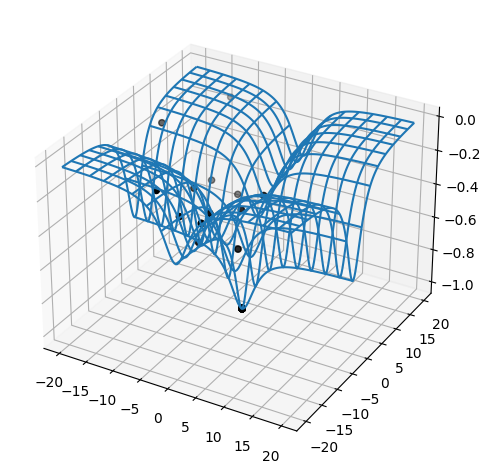

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           9.45470704]
 [  0.           0.        ]
 [  0.          -3.02662845]
 [ -4.11826544   0.        ]
 [  1.23917585  -3.4521872 ]
 [ -8.73686797   0.        ]
 [  0.           0.        ]
 [ -1.08522406   0.        ]
 [ -3.78157025   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -5.86392116 -15.76135723]
 [  0.           0.        ]
 [  0.        

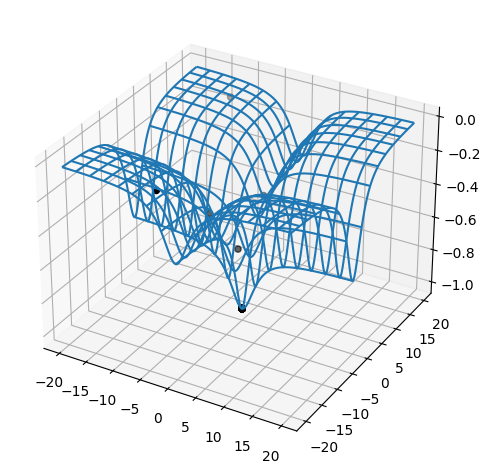

[[ 18.09954887   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-11.96276286   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -7.32493308]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -7.21773691   0.        ]
 [  0.           0.        ]
 [ -4.11826544  -3.02662845]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

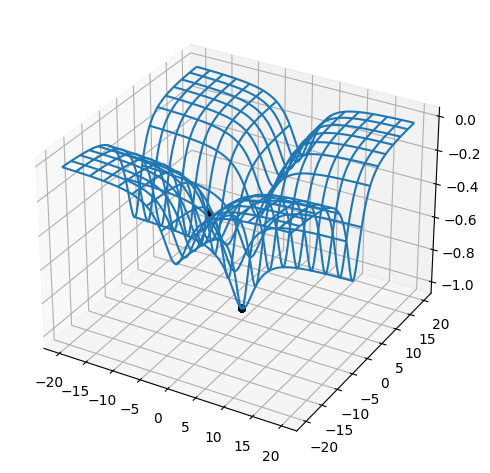

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.         -14.89174296]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  4.9010946    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.65615574   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -3.14578445]
 [  0.           0.        ]
 [  1.55716354   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           3.34525216]
 [  0.           0.        ]
 [-16.76757241   0.        ]
 [  0.        

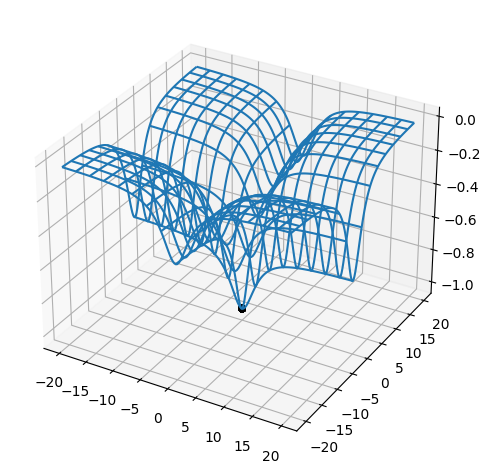

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           2.95271663]
 [  0.           0.        ]
 [-16.48617569   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -0.67152695   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -4.93414204]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -3.5200408    0.        ]
 [  0.           0.        ]
 [  0.        

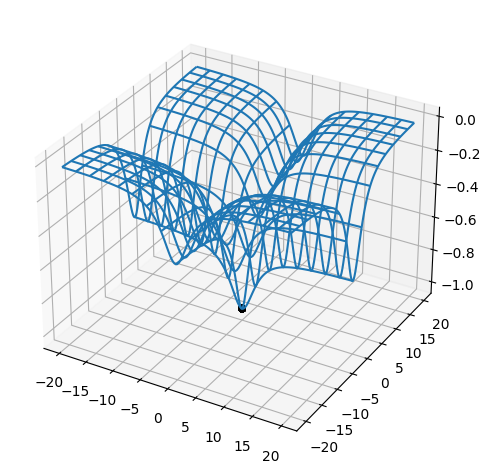

[[  0.           0.        ]
 [ 13.72699622   7.45435088]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -0.11939498]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -3.87140752   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-18.29910625   0.        ]
 [  0.           0.        ]
 [  0.           4.62208607]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           1.0376232 ]
 [ 13.89269057   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          10.78927469]
 [  0.           0.        ]
 [  0.           0.        ]
 [-15.53257067   3.79867195]
 [  0.        

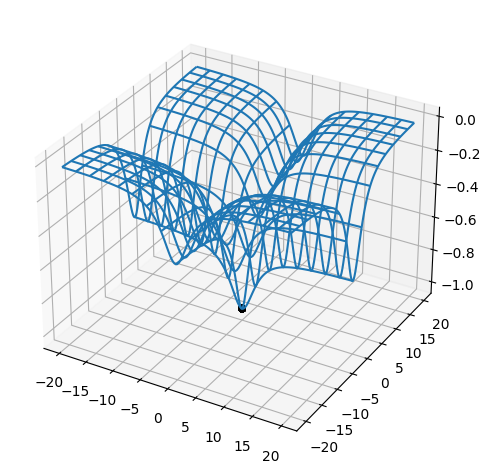

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -13.45272421]
 [  4.57575401   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -5.96984293]
 [-18.86289065   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

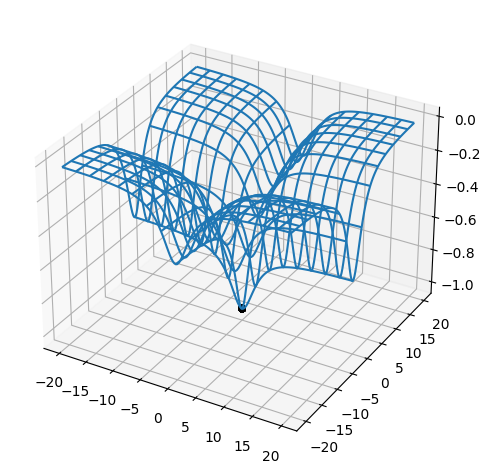

[[  0.           0.        ]
 [  0.          15.88171605]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -7.38712208]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 10.72570238   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  3.69522579   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -14.80186593]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

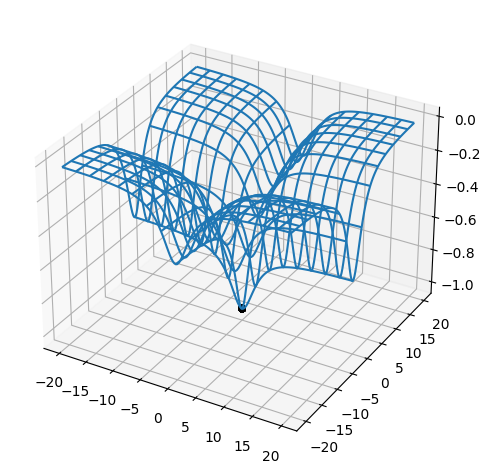

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -11.87704308]
 [  0.           0.        ]
 [ -3.99860628   0.        ]
 [  0.           0.        ]
 [  0.         -10.11390292]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -6.50308998]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          11.68679657]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -5.81489727   0.        ]
 [  0.          -7.68217753]
 [  0.           0.        ]
 [  0.         -14.59441492]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

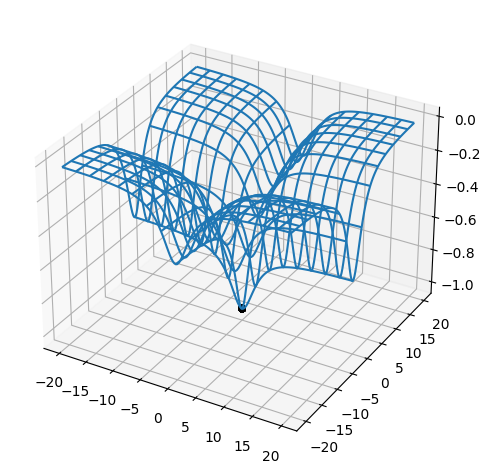

[[  0.           5.28409295]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -5.73952003   0.        ]
 [-17.09210645 -16.1128023 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  6.62566813   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 14.12379122   0.        ]
 [  0.           0.        ]
 [  0.        

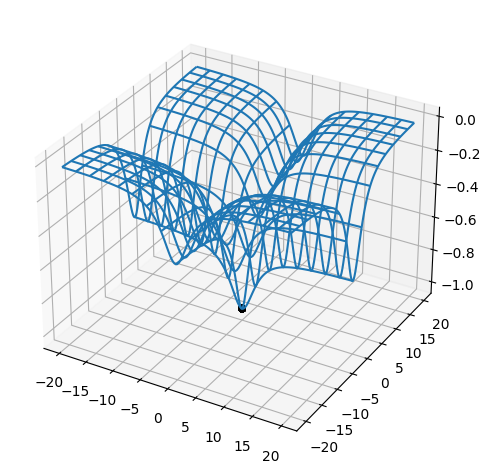

[[  0.           2.92671879]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           6.15079654]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-10.73427565   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  3.75455398   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          15.01806185]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           1.96521359]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-10.24783292   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-16.89840613  -2.20359559]
 [  0.        

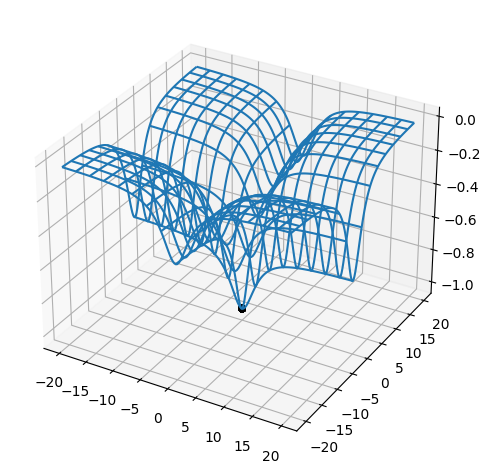

[[  0.           0.        ]
 [  0.          10.9271472 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 17.37798658   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -5.10424143]
 [  0.           0.        ]
 [  0.           0.        ]
 [-16.14209155   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

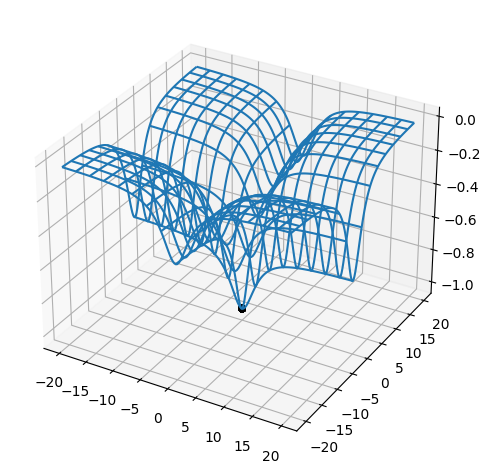

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          19.5521496 ]
 [  0.           0.        ]
 [  0.         -16.74122299]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           2.64312032]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  3.9567683    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 12.63727297   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -1.99097531]
 [-13.80031544   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 17.13201652   0.        ]
 [  0.        

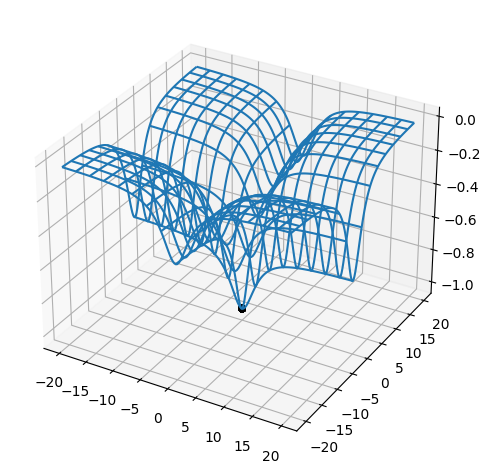

[[ 7.64516906  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         -2.71724763]
 [ 0.         -9.70857936]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-7.55266165  0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         -1.241966  ]
 [ 0.          0.        ]
 

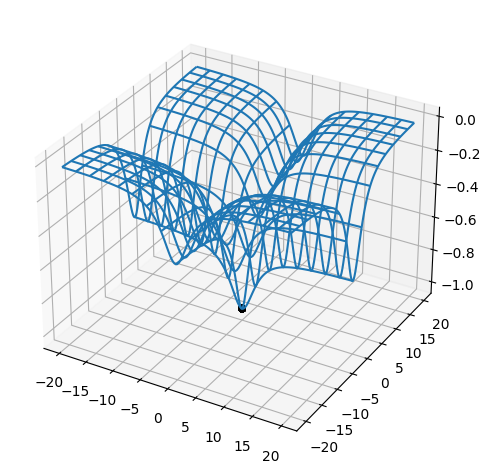

[[  0.96690946  13.29978284]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           4.09061147]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -17.99738793]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          18.42094411]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           3.05579823]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

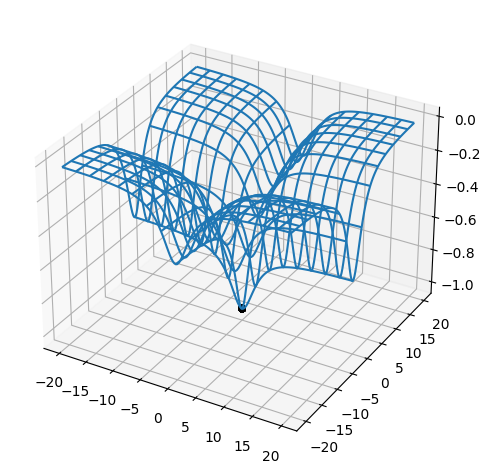

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-10.25132355   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 14.98538699   0.        ]
 [-17.14876138   0.        ]
 [  0.           0.        ]
 [ -3.84026642  11.73731706]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -5.00485624   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           1.26869542]
 [  0.           0.        ]
 [ -2.8694008    0.        ]
 [  0.        

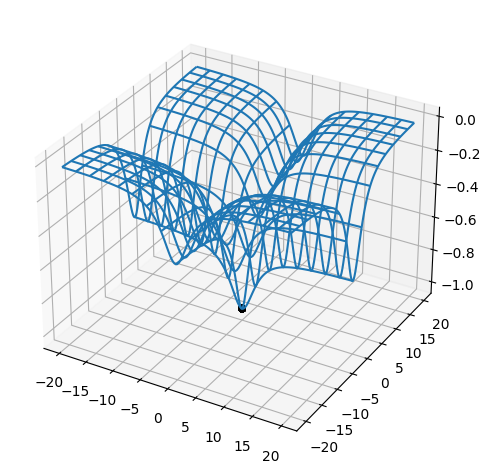

[[  0.          18.2968619 ]
 [  6.9013169    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-11.70084596   0.        ]
 [-12.20635958   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           6.55186831]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -18.03630292]
 [  0.          11.75036243]
 [  0.           0.        ]
 [  0.          18.00767869]
 [  0.           0.        ]
 [ 10.65874398   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 14.33353027   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

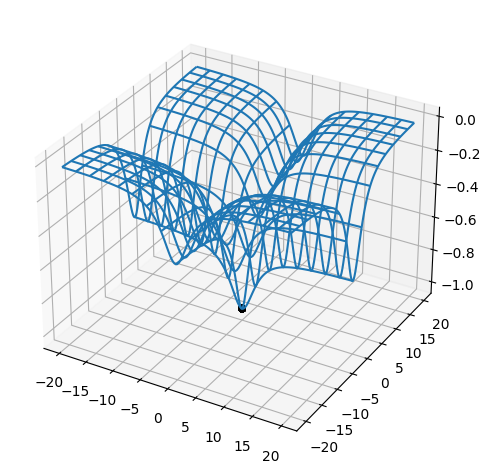

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          13.13665841]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-17.1396205    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-18.08625769   0.        ]
 [  0.        

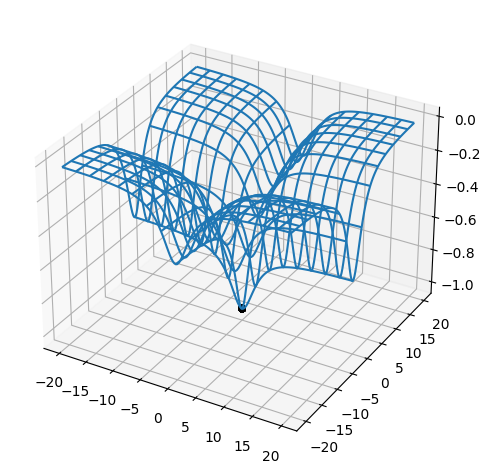

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.82637127]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -2.1772642    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -7.75649822   0.        ]
 [ -7.00899194   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  9.27020747   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          15.43840689]
 [  0.          15.12591502]
 [ -4.09626658   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -9.71657113]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -13.36254197]
 [  0.        

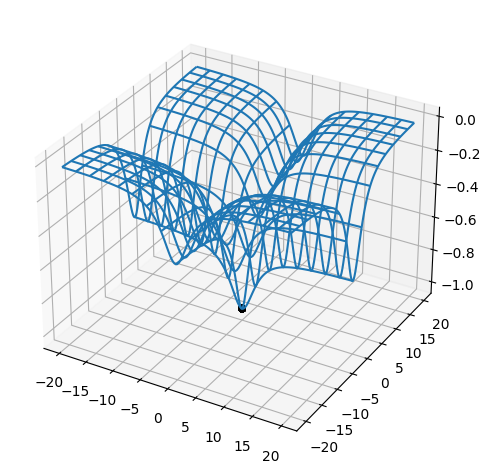

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-18.3552908    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -0.38421399   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ -3.40508177   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -3.13594776]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

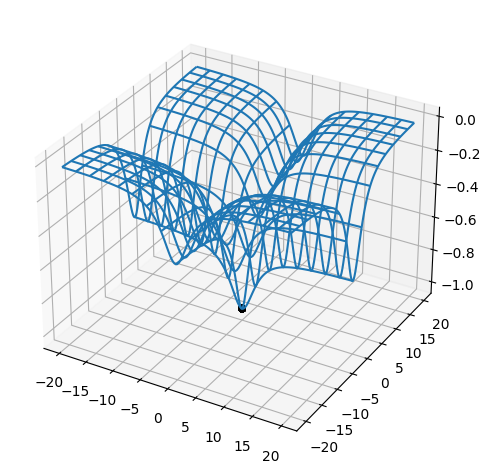

[[  0.           0.        ]
 [ 18.77909875   0.        ]
 [  0.           0.        ]
 [  2.19390035   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.15228373]
 [  0.           0.        ]
 [  0.          11.56820809]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  5.40373537   0.        ]
 [-17.37089122   0.        ]
 [  0.           0.        ]
 [  0.           0.81857894]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -3.37885086]
 [  0.           0.        ]
 [  0.          -5.95365091]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

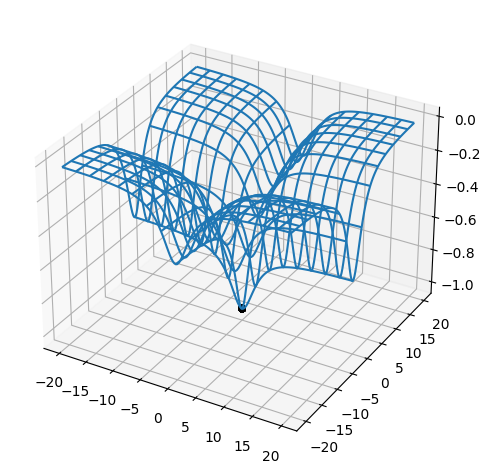

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          11.7993781 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -7.63525361]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          14.66668196]
 [  0.           0.        ]
 [  0.           0.        ]
 [-16.53320479   0.        ]
 [ -5.25032529   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           3.96963391]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -2.68388676]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          11.14107455]
 [  5.1915212    0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

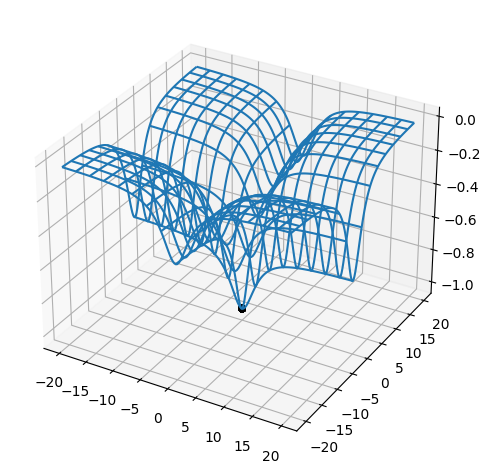

[[  0.           0.        ]
 [  0.         -15.19767279]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [ 10.34217998   0.        ]
 [  0.           0.        ]
 [ -9.9103213    0.        ]
 [  0.          -9.74218537]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          14.25944574]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -0.67462085]
 [  0.           0.        ]
 [  0.17588478   0.        ]
 [  0.           1.63144197]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-19.94770871   0.        ]
 [-10.36381849   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

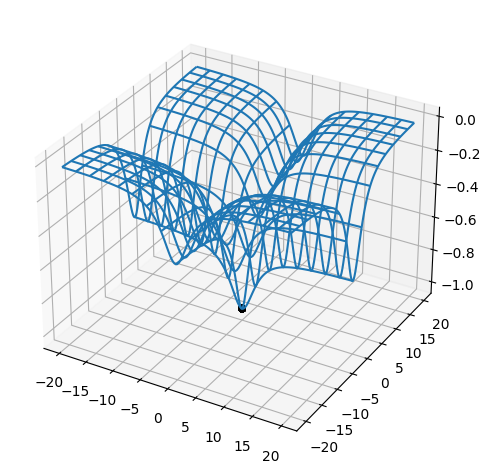

[[  0.           0.        ]
 [  5.57104716   0.        ]
 [  0.           0.        ]
 [  0.           2.26155015]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           3.6917042 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -1.48325995]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          12.94734342]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

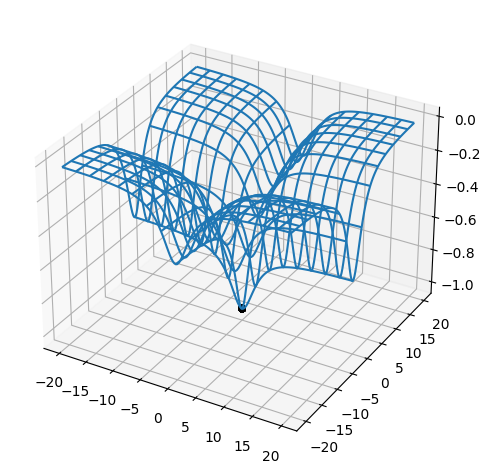

[[  0.           0.        ]
 [  0.12447466   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           9.27051214]
 [  0.           0.        ]
 [  0.           0.        ]
 [-18.78695463   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [-10.83447434   0.        ]
 [  0.           0.        ]
 [  0.         -19.85088899]
 [  0.           7.15586309]
 [  5.6484554    0.        ]
 [  0.           0.        ]
 [  0.           0.19772576]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  1.23666551   0.        ]
 [  0.          -4.17981913]
 [  0.         -11.108688  ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

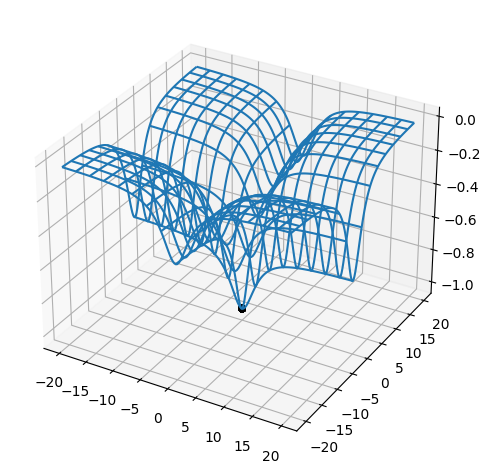

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.         -10.78837712]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          -6.55354722]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

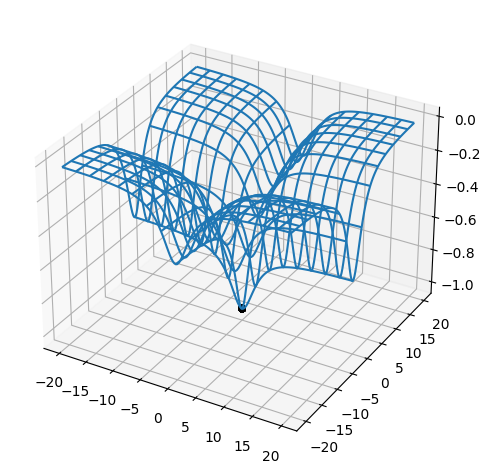

[[  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          10.80224561]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          13.72199651]
 [  0.          -9.48119784]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  3.05515839 -11.37953653]
 [  0.           0.        ]
 [  0.           0.        ]
 [  9.10310906   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.         -10.2496372 ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

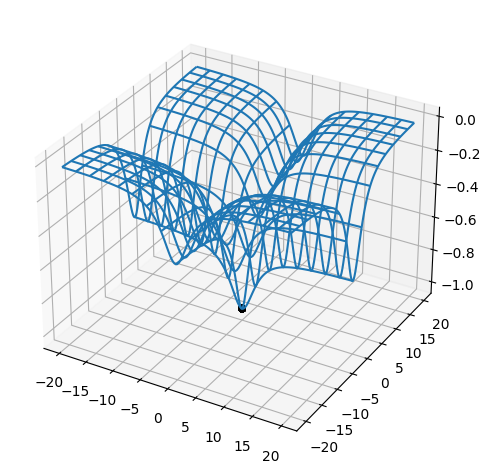

[[  0.           0.        ]
 [-12.68845019   0.        ]
 [  0.           0.        ]
 [ 19.85699359   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  4.30000862   0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.          11.28481338]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.        

KeyboardInterrupt: ignored

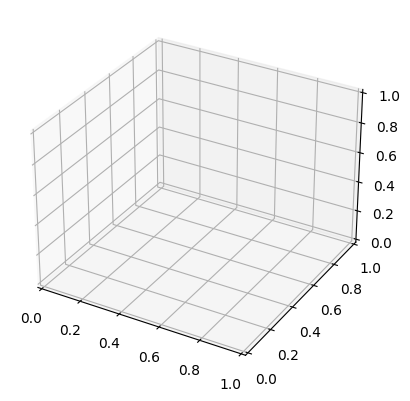

In [75]:
ga = GeneticAlgorithm(population_size=100, num_genes=2, num_parents=50, mutation_prob=0.1, selection_method="roulette", parent_selection_method="panmixing")

ga.learn(num_generations=100)

